
# Net Worth by Date
## Load the various utility libraries to setup the notebook

In [1]:

import os.path as osp
shared_folder = osp.abspath(osp.join('..', '..', 'share'))
import sys
if shared_folder not in sys.path: sys.path.insert(1, shared_folder)
from notebook_utils import NotebookUtilities
nu = NotebookUtilities(
    data_folder_path=osp.abspath(osp.join('..', 'data')),
    saves_folder_path=osp.abspath(osp.join('..', 'saves'))
)

# Import needed libraries
from datetime import datetime
from pandas import DataFrame
from scipy.optimize import fsolve, curve_fit
import locale, re
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as mticker
%matplotlib inline

# Use the following only if you are on a high definition device
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('retina')

# Add python folder to system path and reuglify print
sys.path.insert(1, osp.abspath('../py'))
%pprint

Pretty printing has been turned OFF



## Simple functions

In [2]:

# Define the exponential decay function
exp_decay = lambda x, y0, yp, K: y0 + (yp - y0) * (1 - np.exp(-K * (x-X0)))

# Define the default xtick formatting function
xtick_year_fn = lambda x: datetime.fromtimestamp(x).strftime('%Y')

In [3]:

def get_r_squared_string(xdata, ydata, prefix_str=''):
    
    # Get r squared value
    inf_nan_mask = nu.get_inf_nan_mask(xdata, ydata)
    from scipy.stats import pearsonr
    pearsonr_tuple = pearsonr(xdata[inf_nan_mask], ydata[inf_nan_mask])
    pearson_r = pearsonr_tuple[0]
    pearsonr_statement = str('%.2f' % pearson_r)
    coefficient_of_determination_statement = str('%.2f' % pearson_r**2)
    p_value = pearsonr_tuple[1]
    
    if p_value < 0.0001: pvalue_statement = '<0.0001'
    else: pvalue_statement = '=' + str('%.4f' % p_value)
    
    s_str = prefix_str + f': $r^2=' + coefficient_of_determination_statement + ',\ p' + pvalue_statement + '$'
    
    return s_str

In [4]:

from pandas import Series

def plot_money_over_time(xdata, ydata, line_fit, y0, yp, K, X0, smoothx, ylabel, coefficients, fig_height=6, xtick_fn=xtick_year_fn, verbose=True):
    
    # Create the figure and subplot
    fig, ax = plt.subplots(figsize=(fig_height*nu.twitter_aspect_ratio, fig_height))
    fig.tight_layout()
    
    # Plot the original data points
    ax.plot(xdata, ydata, 'b.', label='Original Data')  # Plot data points
    
    # Plot the fitted line
    ax.plot(xdata, line_fit, color='red', linewidth=1, alpha=0.5, label='Linear Fit')
    
    # Define a function to evaluate the fitted exponential decay curve at any x
    exponential_decay_fit = lambda x: y0 + (yp - y0) * (1 - np.exp(-K * (x-X0)))
    
    # Plot the best-fit curve
    ax.plot(smoothx, exponential_decay_fit(smoothx), 'g-', label='Exponential Decay Fit', linewidth=1, alpha=0.5)  # Plot the fitted curve
    
    # Set labels, legend, and title
    ax.set_xlabel('Record Date')
    ax.set_ylabel(f'{ylabel}')
    ax.set_title(f'{ylabel} vs. Record Date')
    
    # Show legend
    ax.legend(loc='upper left')
    
    # Get annotation positions
    equations_left = 0.678
    predictions_left = 0.45
    predictions_top = 0.03
    
    # Annotate the linear fit
    s_str = 'Linear Fit: ' + nu.get_r_squared_value_latex(Series(xdata), Series(line_fit))
    text_tuple = ax.text(equations_left, 0.95, s_str, alpha=0.5, transform=ax.transAxes, fontsize='10')
    
    # Solve the equation for Record Date
    record_date = (0 - coefficients[1]) / coefficients[0]
    date_str = datetime.fromtimestamp(record_date).strftime('%A, %B %d, %Y')
    text_str = f'Record Date where Linear Fit equals zero {ylabel}: {date_str}'
    if verbose: print(text_str)
    text_tuple = ax.text(predictions_left, predictions_top, text_str, alpha=0.5, transform=ax.transAxes, fontsize=8)
    
    # Annotate the exponential fit
    s_str = 'Exponential Decay Fit: ' + nu.get_r_squared_value_latex(Series(smoothx), Series(exponential_decay_fit(smoothx)))
    text_tuple = ax.text(equations_left, 0.9, s_str, alpha=0.5, transform=ax.transAxes, fontsize='10')
    
    # Define the function to find the root of (exponential_decay_fit - ydatum)
    fsolve_equation = lambda record_date, ydatum: exponential_decay_fit(record_date) - ydatum
    
    # Solve the equation for record_date
    record_date_solution = fsolve(fsolve_equation, x0=X0, args=(0))
    date_str = datetime.fromtimestamp(record_date_solution[0]).strftime('%A, %B %d, %Y')
    text_str = f'Record Date where Exponential Decay Fit equals zero {ylabel}: {date_str}'
    if verbose: print(text_str)
    text_tuple = ax.text(
        predictions_left, predictions_top - 0.02, text_str, alpha=0.5, transform=ax.transAxes, fontsize=8
    )
    
    # Add currency markers and commas to the y ticks
    yticklabels_list = []
    for text_obj in ax.get_yticklabels():
        text_obj.set_text(locale.currency(text_obj.get_position()[1], grouping=True))
        yticklabels_list.append(text_obj)
    ax.set_yticklabels(yticklabels_list)
    
    # Turn the x ticks into year numbers
    xticklabels_list = []
    for text_obj in ax.get_xticklabels():
        text_obj.set_text(xtick_fn(text_obj.get_position()[0]))
        xticklabels_list.append(text_obj)
    ax.set_xticklabels(xticklabels_list)
    if verbose: print(xticklabels_list)
    
    # Show the plot
    plt.show()


## Clean and preprocess the annual earnings dataset

In [5]:

from xml.etree import ElementTree as ET

file_path = '../data/xml/social-security-statement.xml'
tree = ET.parse(file_path)
root = tree.getroot()

In [6]:

rows_list = []
for element_obj in root.iter():
    row_dict = element_obj.attrib
    row_dict['column_name'] = element_obj.tag
    tag_text = element_obj.text.strip()
    row_dict['column_value'] = tag_text
    rows_list.append(row_dict)
social_security_df = DataFrame(rows_list)

In [7]:

mask_series = ~social_security_df.startYear.isnull()

# Create a series with shifted values by 1 position
next_row_mask = mask_series.shift(1)

# Filter for rows where the original mask was True or the shifted mask is True
df = social_security_df[mask_series | next_row_mask ].rename(columns={'startYear': 'start_year', 'endYear': 'end_year', 'column_value': 'annual_earnings'})

# Forward fill then backward fill to remove NaNs
df = df.fillna(method='ffill').fillna(method='bfill')

mask_series = (df.column_name == 'FicaEarnings')
columns_list = ['start_year', 'annual_earnings']
left_df = df[mask_series][columns_list].reset_index(drop=True)
left_df.start_year = left_df.start_year.astype('int64')
left_df.annual_earnings = left_df.annual_earnings.astype('int64')

In [8]:

# Add Mimi's data by year
from pandas import Index

columns_list = ['start_year', 'spousal_earnings']
right_df = DataFrame([
    {'start_year': 1975, 'spousal_earnings': 170},
    {'start_year': 1976, 'spousal_earnings': 0},
    {'start_year': 1977, 'spousal_earnings': 0},
    {'start_year': 1978, 'spousal_earnings': 615},
    {'start_year': 1979, 'spousal_earnings': 625},
    
    {'start_year': 1980, 'spousal_earnings': 2110},
    {'start_year': 1981, 'spousal_earnings': 1533},
    {'start_year': 1982, 'spousal_earnings': 0},
    {'start_year': 1983, 'spousal_earnings': 3564},
    {'start_year': 1984, 'spousal_earnings': 10716},
    {'start_year': 1985, 'spousal_earnings': 9242},
    {'start_year': 1986, 'spousal_earnings': 8596},
    {'start_year': 1987, 'spousal_earnings': 13224},
    {'start_year': 1988, 'spousal_earnings': 15575},
    {'start_year': 1989, 'spousal_earnings': 4776},
    
    {'start_year': 1990, 'spousal_earnings': 0},
    {'start_year': 1991, 'spousal_earnings': 0},
    {'start_year': 1992, 'spousal_earnings': 0},
    {'start_year': 1993, 'spousal_earnings': 436},
    {'start_year': 1994, 'spousal_earnings': 3768},
    {'start_year': 1995, 'spousal_earnings': 7310},
    {'start_year': 1996, 'spousal_earnings': 3653},
    {'start_year': 1997, 'spousal_earnings': 3305},
    {'start_year': 1998, 'spousal_earnings': 3098},
    {'start_year': 1999, 'spousal_earnings': 1260},
    
    {'start_year': 2000, 'spousal_earnings': 0},
    {'start_year': 2001, 'spousal_earnings': 0},
    {'start_year': 2002, 'spousal_earnings': 0},
    {'start_year': 2003, 'spousal_earnings': 0},
    {'start_year': 2004, 'spousal_earnings': 0},
    {'start_year': 2005, 'spousal_earnings': 0},
    {'start_year': 2006, 'spousal_earnings': 0},
    {'start_year': 2007, 'spousal_earnings': 0},
    {'start_year': 2008, 'spousal_earnings': 0},
    {'start_year': 2009, 'spousal_earnings': 0},
    
    {'start_year': 2010, 'spousal_earnings': 0},
    {'start_year': 2011, 'spousal_earnings': 0},
    {'start_year': 2012, 'spousal_earnings': 0},
    {'start_year': 2013, 'spousal_earnings': 1985},
    {'start_year': 2014, 'spousal_earnings': 8703},
    {'start_year': 2015, 'spousal_earnings': 13299},
    {'start_year': 2016, 'spousal_earnings': 19304},
    {'start_year': 2017, 'spousal_earnings': 16811},
    {'start_year': 2018, 'spousal_earnings': 7476},
    {'start_year': 2019, 'spousal_earnings': 14317},
    
    {'start_year': 2020, 'spousal_earnings': 20606},
    {'start_year': 2021, 'spousal_earnings': 31832},
    {'start_year': 2022, 'spousal_earnings': 22501},
    {'start_year': 2023, 'spousal_earnings': 30004},
], columns=columns_list)
right_df.start_year = right_df.start_year.astype('int64')
right_df.spousal_earnings = right_df.spousal_earnings.astype('int64')

In [9]:

on_columns = sorted(set(left_df.columns).intersection(set(right_df.columns)))
annual_earnings_df = left_df.merge(right_df, on=on_columns, how='outer').fillna(0).astype('int64')

In [10]:

annual_earnings_df['total_earnings'] = annual_earnings_df.annual_earnings + annual_earnings_df.spousal_earnings


## Visualize the interesting aspects


guess_y0, guess_yp, guess_K = -12841.395252841374, 428717595.3630753, 0.0000000000

y0 = ($12,841.40)
yp = $428,717,595.36
K = 0.0000000000



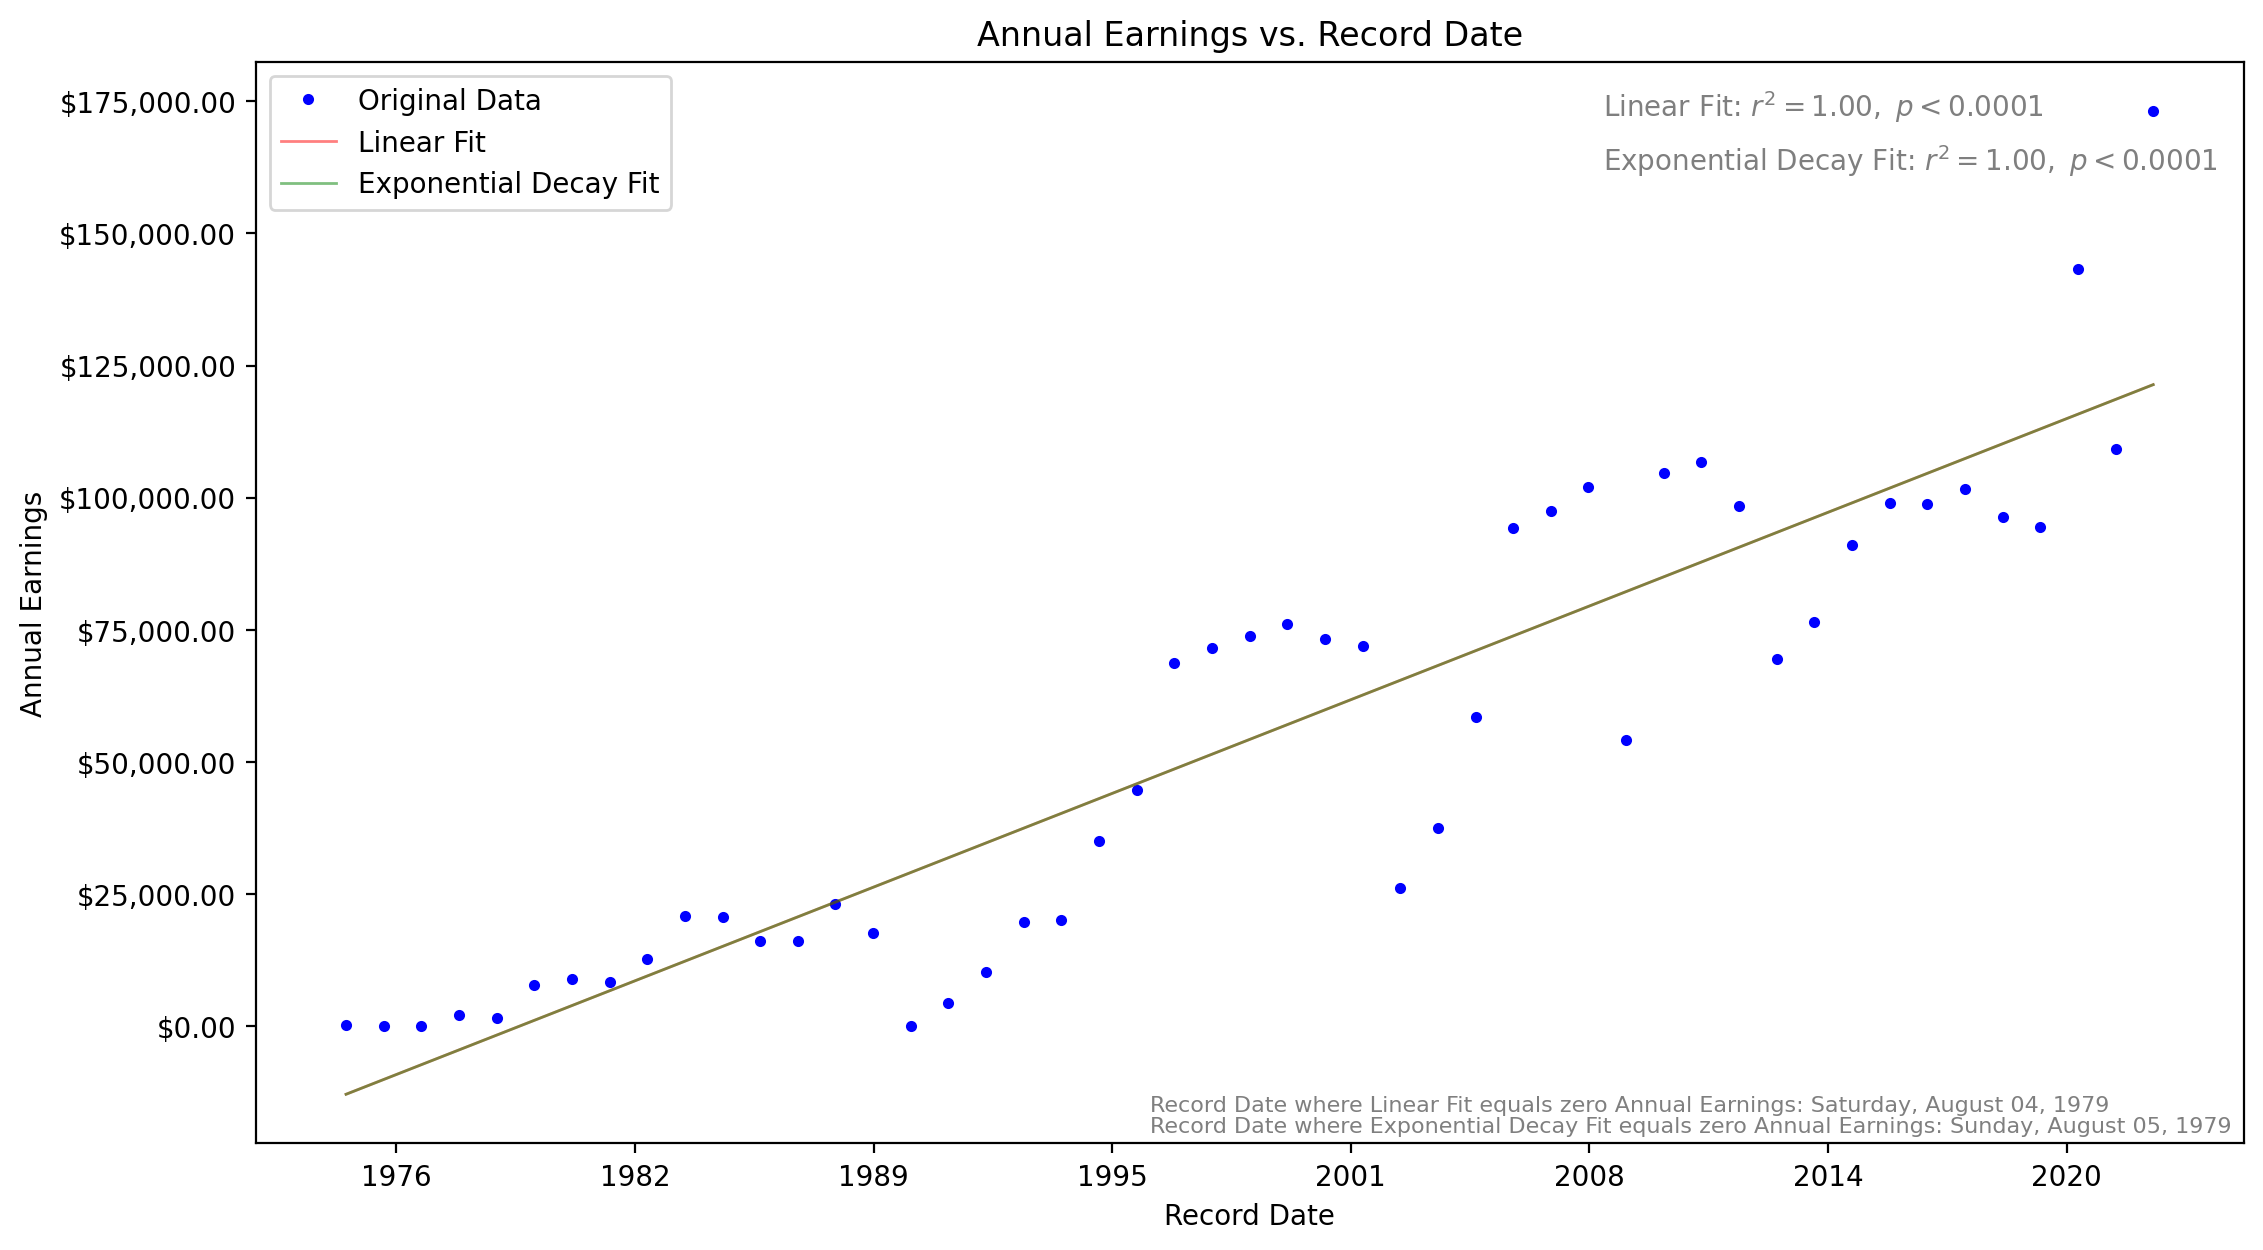

In [11]:

# Get record dates and annual earnings values
earnings_dates = np.array([datetime.strptime(str(d), '%Y').timestamp() for d in annual_earnings_df.start_year])
X0 = earnings_dates[0]  # Initial value of earnings_dates
annual_earnings = annual_earnings_df.total_earnings.map(lambda x: int(x)).values

# Initial guess for the parameters of the exponential decay curve
# The parameters of the exponential decay function have the following meanings:
# guess_y0: The y-intercept of the exponential decay curve.
# guess_yp: The initial value of the exponential decay curve.
# guess_K: The decay rate of the exponential decay curve.
guess_y0, guess_yp, guess_K = -9894.953196451443, 409000.4928816755, 0.0000000002

# Fit the exponential decay function to the data using curve fitting
params, cov = curve_fit(exp_decay, earnings_dates, annual_earnings, p0=[guess_y0, guess_yp, guess_K], maxfev=8000)

# Extract the parameters of the fitted exponential decay curve
y0, yp, K = params

# Print the fitted parameters for reintroduction as guesses
print(f'\nguess_y0, guess_yp, guess_K = {y0}, {yp}, {K:,.10f}\n')

# Print the fitted parameters for visualization
locale.setlocale(locale.LC_ALL, 'en_US')
print(f'y0 = {locale.currency(y0, grouping=True)}\nyp = {locale.currency(yp, grouping=True)}\nK = {K:,.10f}\n')

# Fit a line to the data points
coefficients = np.polyfit(earnings_dates, annual_earnings, 1)

# Add to parameters a line using the fitted coefficients and a smoother x range for plotting the fitted curve
plot_money_over_time(
    xdata=earnings_dates, ydata=annual_earnings, line_fit=np.polyval(coefficients, earnings_dates), y0=y0, yp=yp, K=K, X0=X0,
    smoothx=np.linspace(X0, earnings_dates[-1], 20), ylabel='Annual Earnings', coefficients=coefficients, verbose=False
)


## Clean and preprocess the net worth dataset

In [9]:

import pyperclip

file_path = osp.join(nu.data_folder, 'txt', 'Net_Worth_by_Date.txt')
pyperclip.copy(str(osp.abspath(file_path)))
with open(file_path, 'r', encoding='utf-8') as f: export_str = f.read()

In [10]:

lines_list = export_str.split('\n')[1:-1]
currency_regex = re.compile('[^0-9.-]+')
rows_list = []
for date_str, worth_str in zip(lines_list[::2], lines_list[1::2]):
    row_dict = {}
    datetime_obj = datetime.strptime(date_str, '- %A, %B %d, %Y')
    row_dict['record_date'] = datetime_obj
    net_worth = float(currency_regex.sub('', worth_str))
    row_dict['net_worth'] = net_worth
    rows_list.append(row_dict)
net_worth_df = DataFrame(rows_list)


## Visualize the interesting aspects


guess_y0, guess_yp, guess_K = -50437.55752108721, -22661.438760644152, 0.0000000271

y0 = ($50,437.56)
yp = ($22,661.44)
K = 0.0000000271



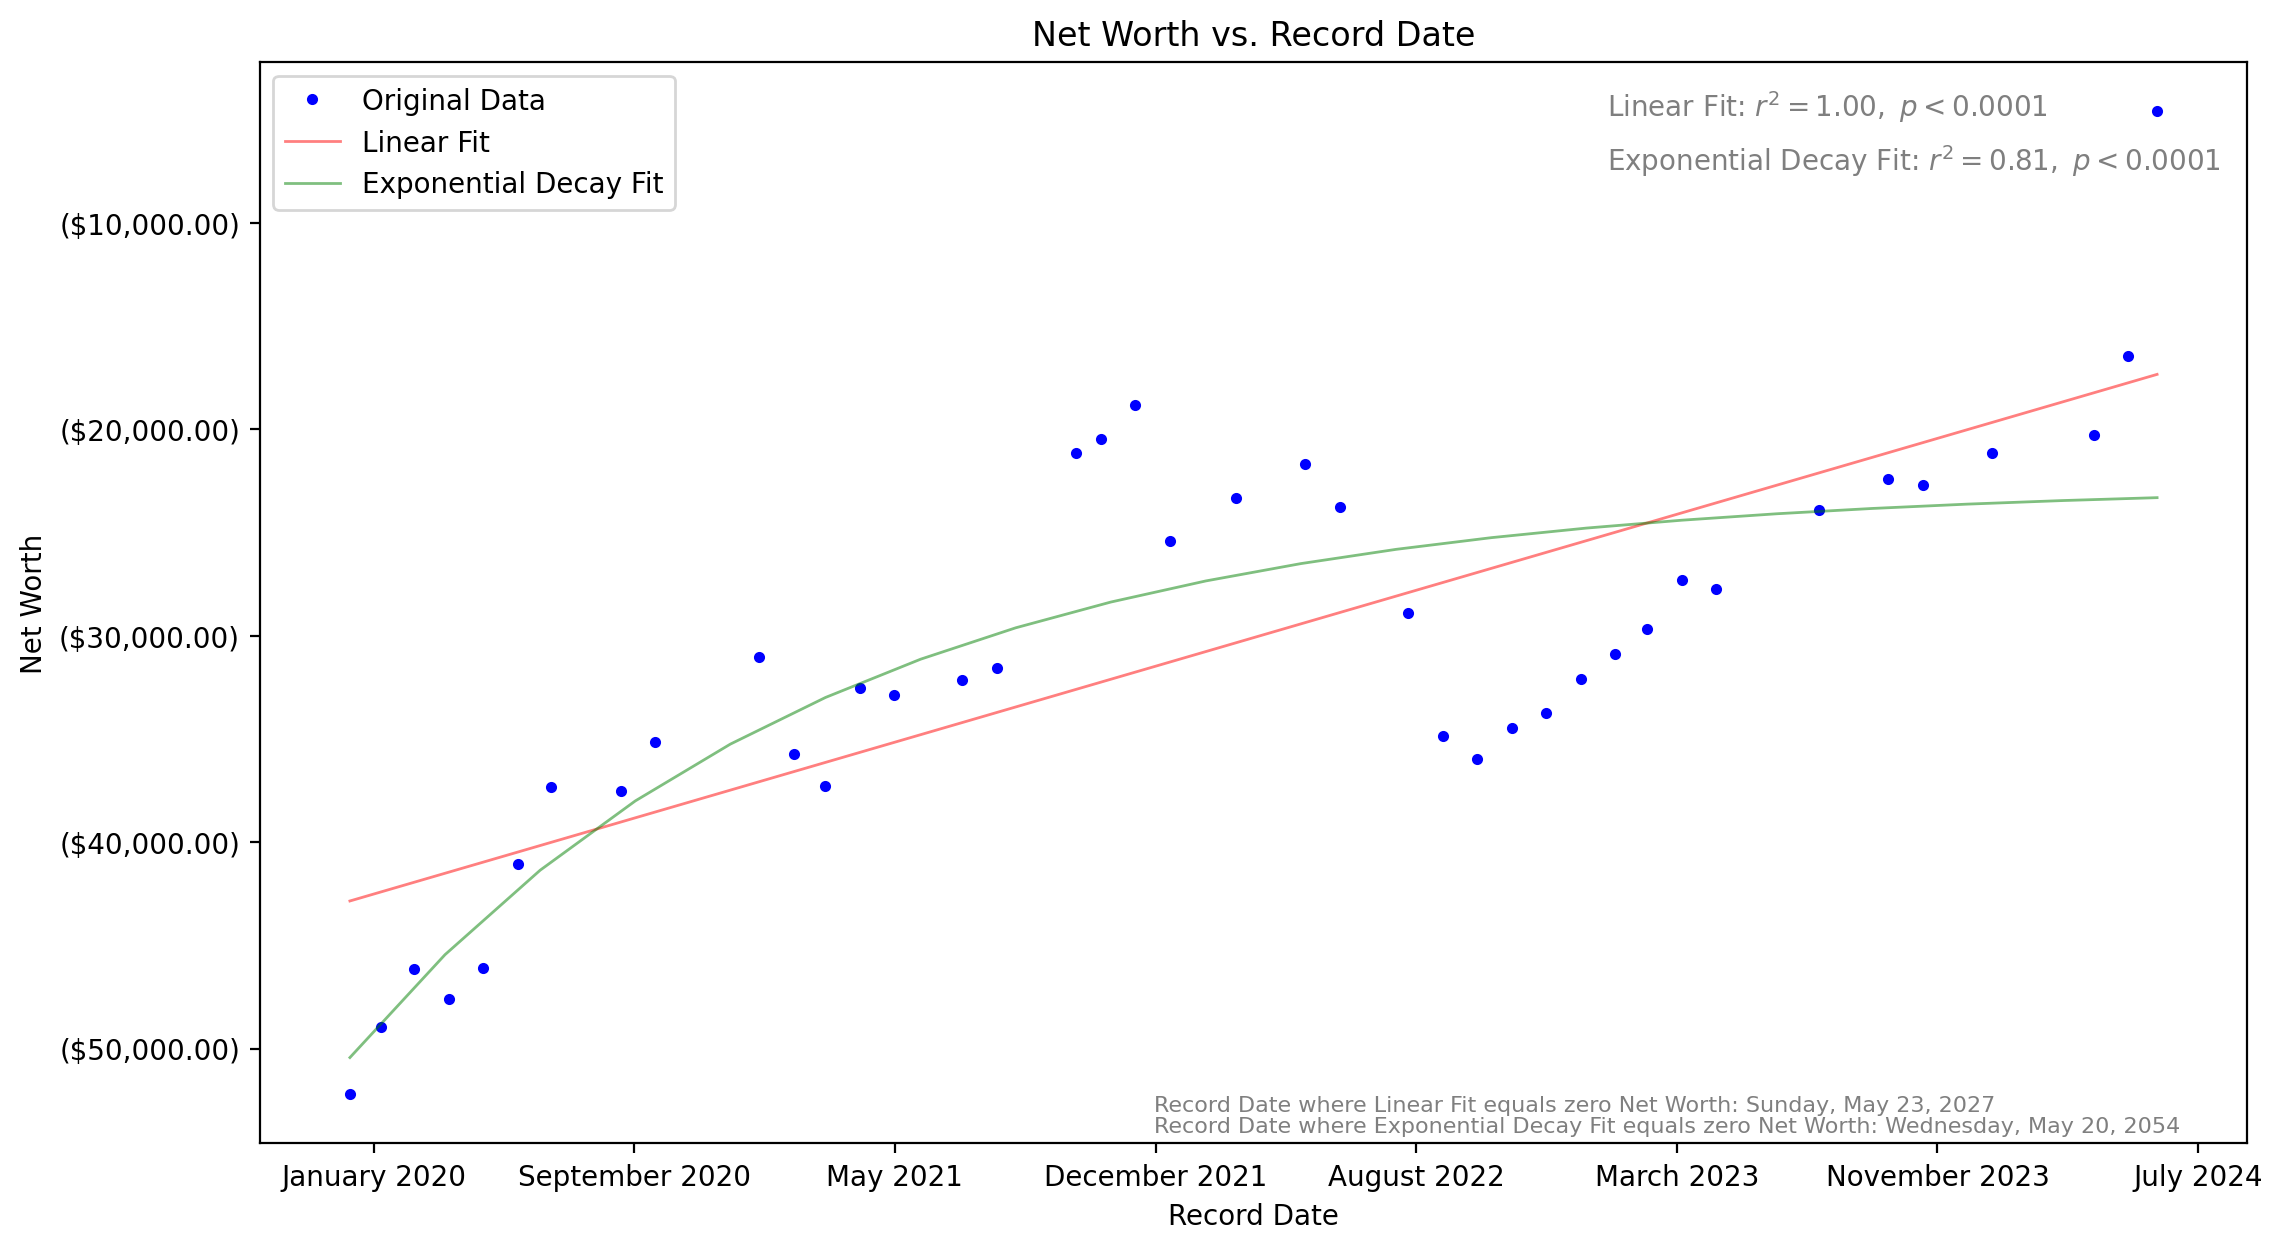

In [11]:

# Get record dates and net worth values
net_worth_dates = np.array([d.timestamp() for d in net_worth_df.record_date])
X0 = net_worth_dates[0]  # Initial value of net_worth_dates
net_worths = net_worth_df.net_worth.values

# Initial guess for the parameters of the exponential decay curve
# The parameters of the exponential decay function have the following meanings:
# guess_y0: The y-intercept of the exponential decay curve.
# guess_yp: The initial value of the exponential decay curve.
# guess_K: The decay rate of the exponential decay curve.
guess_y0, guess_yp, guess_K = -52017.44287550526, -25315.241591280737, 0.0000000378

# Fit the exponential decay function to the data using curve fitting
params, cov = curve_fit(exp_decay, net_worth_dates, net_worths, p0=[guess_y0, guess_yp, guess_K])

# Extract the parameters of the fitted exponential decay curve
y0, yp, K = params

# Print the fitted parameters for reintroduction as guesses
print(f'\nguess_y0, guess_yp, guess_K = {y0}, {yp}, {K:,.10f}\n')

# Print the fitted parameters for visualization
locale.setlocale(locale.LC_ALL, 'en_US')
print(f'y0 = {locale.currency(y0, grouping=True)}\nyp = {locale.currency(yp, grouping=True)}\nK = {K:,.10f}\n')

# Define a xtick formatting function that displays years and months
xtick_year_month_fn = lambda x: datetime.fromtimestamp(x).strftime('%B %Y')

# Fit a line to the data points
coefficients = np.polyfit(net_worth_dates, net_worths, 1)

# Add to parameters a line using the fitted coefficients and a smoother x range for plotting the fitted curve
plot_money_over_time(
    xdata=net_worth_dates, ydata=net_worths, line_fit=np.polyval(coefficients, net_worth_dates), y0=y0, yp=yp, K=K, X0=X0,
    smoothx=np.linspace(X0, net_worth_dates[-1], 20), ylabel='Net Worth', coefficients=coefficients, xtick_fn=xtick_year_month_fn, verbose=False
)

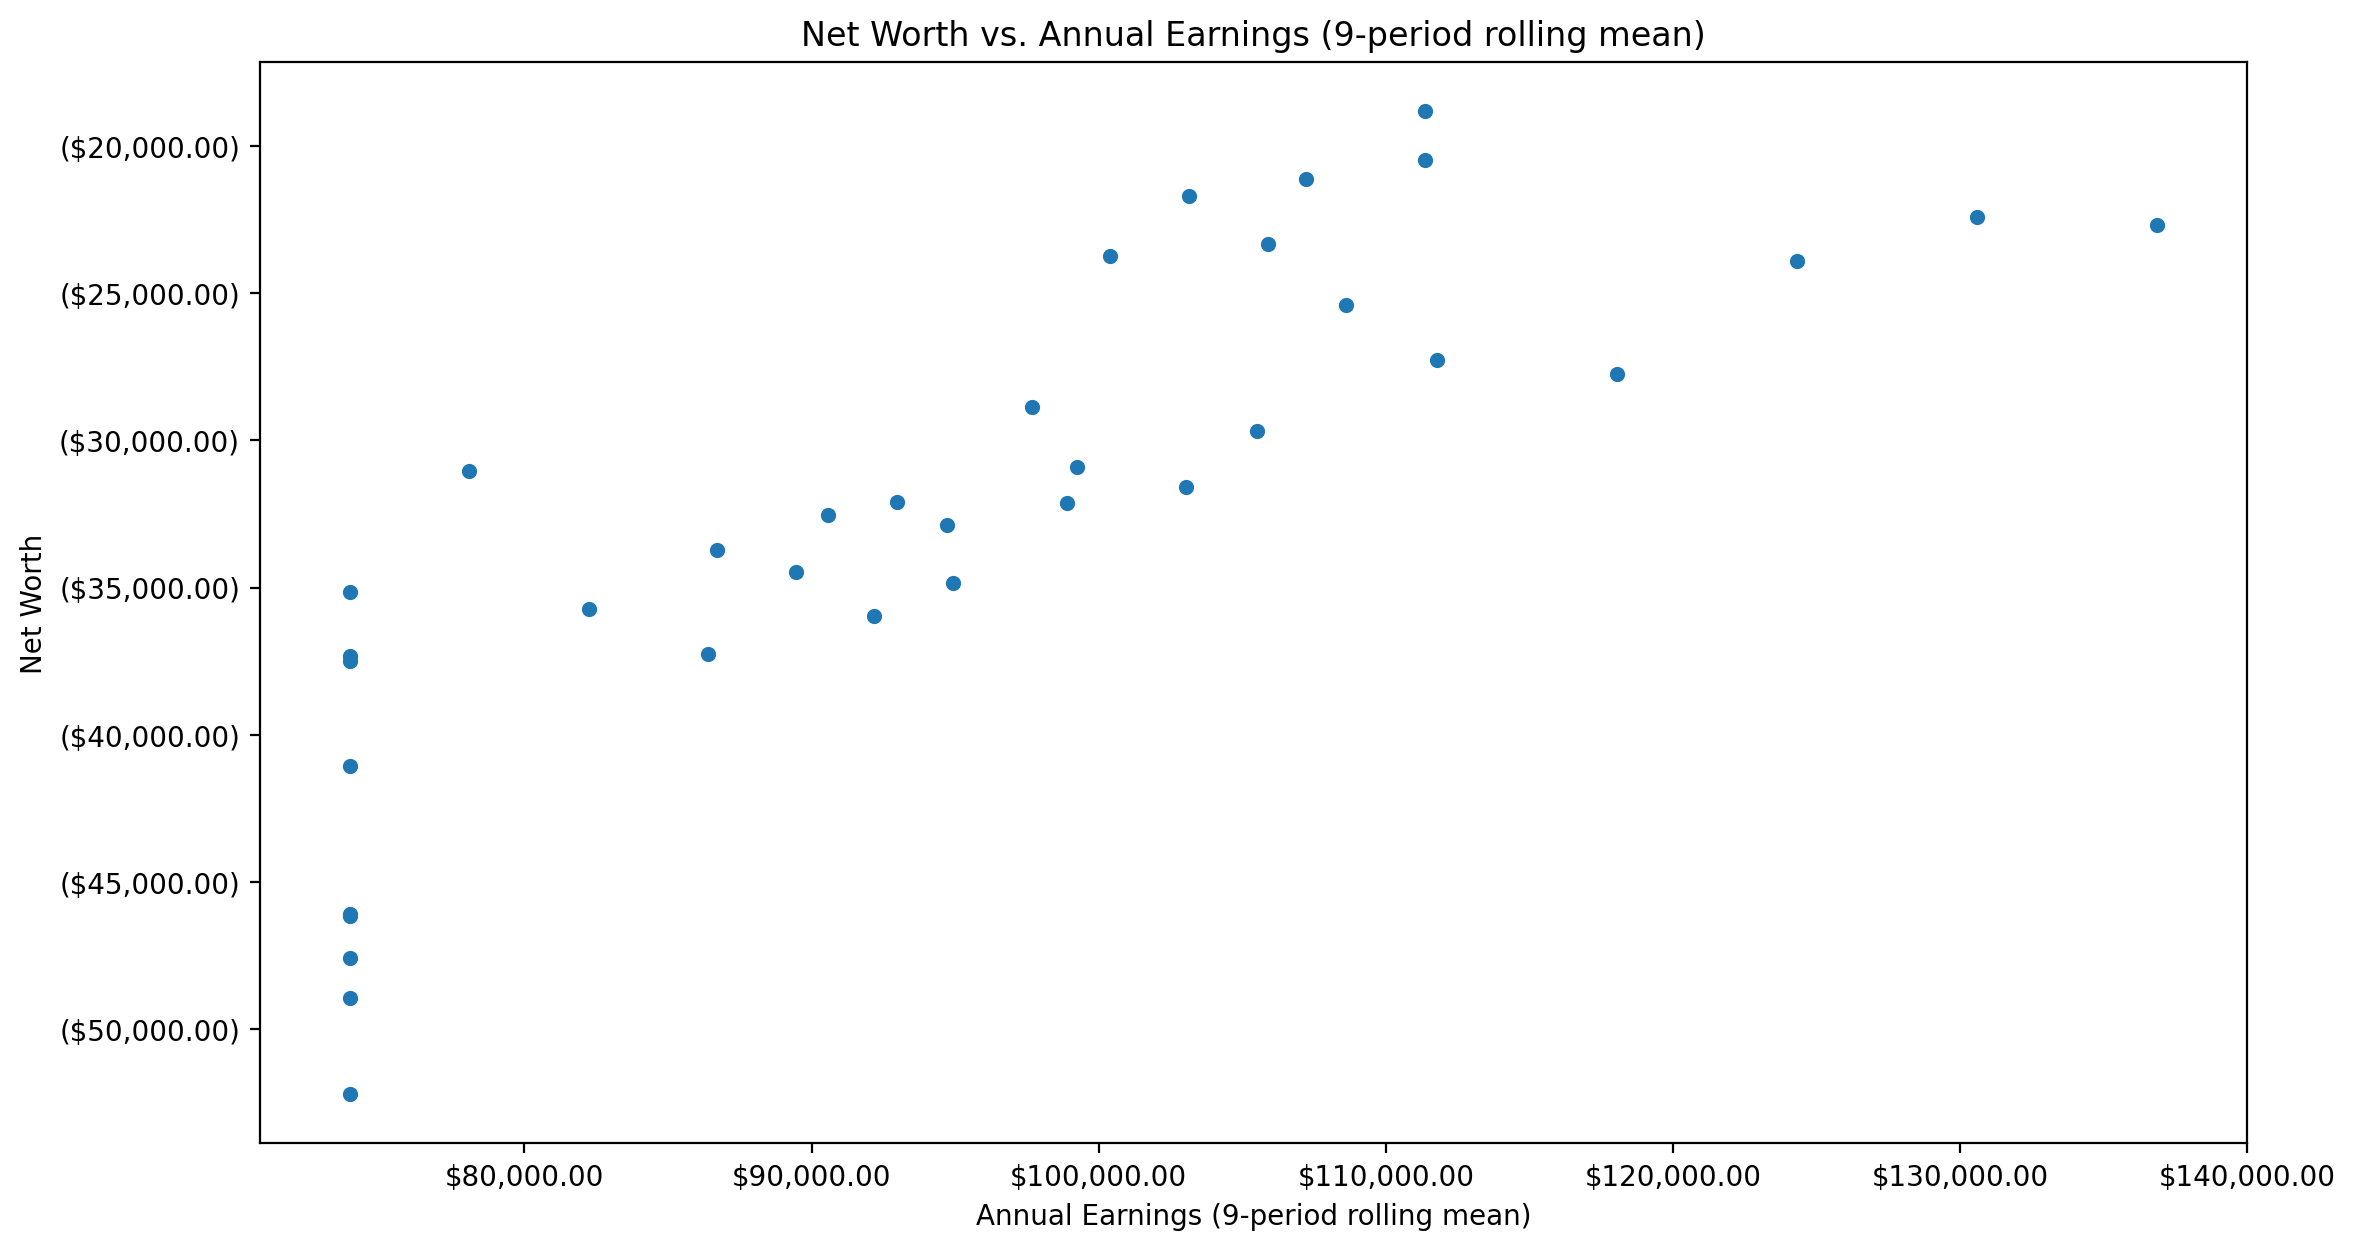

In [12]:

if 'record_date' not in net_worth_df.columns: net_worth_df = net_worth_df.reset_index(drop=False)
net_worth_df['start_year'] = net_worth_df.record_date.map(lambda x: x.year)
df = net_worth_df.merge(annual_earnings_df, on=['start_year']).sort_values(['record_date'])
window = 9
df['rolling_earnings'] = df.annual_earnings.rolling(window=window, min_periods=1).mean()

# Create the figure and subplot
fig_height = 6
fig, ax = plt.subplots(figsize=(fig_height*nu.twitter_aspect_ratio, fig_height))
fig.tight_layout()

# Extract unique annual earnings values and set them as xticks
# unique_earnings = df.annual_earnings.unique()
# ax.set_xticks(unique_earnings)

df.plot(x='rolling_earnings', y='net_worth', kind='scatter', ax=ax)

# Add currency markers and commas to the x ticks
xticklabels_list = []
for text_obj in ax.get_xticklabels():
    text_obj.set_text(locale.currency(text_obj.get_position()[0], grouping=True))
    xticklabels_list.append(text_obj)
ax.set_xticklabels(xticklabels_list)

# Add currency markers and commas to the y ticks
yticklabels_list = []
for text_obj in ax.get_yticklabels():
    text_obj.set_text(locale.currency(text_obj.get_position()[1], grouping=True))
    yticklabels_list.append(text_obj)
ax.set_yticklabels(yticklabels_list)
# print(yticklabels_list)

# Set labels, legend, and title
xlabel = f'Annual Earnings ({window}-period rolling mean)'
ylabel = 'Net Worth'
ax.set_xlabel(f'{xlabel}')
ax.set_ylabel(f'{ylabel}')
ax.set_title(f'{ylabel} vs. {xlabel}')

# Show the plot
plt.show()